Chlorophyll algorithms from ocean color remote sensing missions come in two flavors, semi-analytical and empirical. The latter type is typically a band ratio based polynomial regression model, obtained via least squares fitting. These model are usually more successful than their analytical counterparts and as a result are part of the operational algorithmic arsenal used by the Ocean Biology Processing Group at NASA Goddard. 

Here I will focus on the OC4 algorithm, part of the OCx family of empirical algorithms, which are  generally expressed as follows.
$$ log_{10}\left(chlor_a\right) = a_0 + \sum_{i=1}^{4}a_ilog_{10}\left(\frac{max\left(Rrs\left(\lambda_{blue}\right)\right)}{Rrs\left(\lambda_{green}\right)}\right)^i$$

For this exercise I will load a dataset that is as close as possible to the dataset used for the calculation of the coefficients of the OC4 polynomial, the latest of which are [OC4v6](https://oceancolor.gsfc.nasa.gov/atbd/chlor_a/)), obtained a few years ago using a frequentist least squares regression. I am then going to do my own least squares fit using the present dataset.I will then repeat the exercise using a bayesian regression approach, and explore the much richer information content of the inference results.

I created the dataset I will use here with a similar approach to that in an [earlier post](https://madhatter106.github.io/DataScienceCorner/posts/getting-nomadata-into-a-pandas-dataframe/), with the difference that the data used here was extracted from the NOMAD v.2 dataset to mimick as much as possible the data selection process described in O'Reilly *et al.* (1998, 2000). Note that having not found a description of the feature selection from the NOMAD v2 data set used for the derivation of the updated OC4v6 coefficients, the resulting coefficients may be somewhat different from those making up NASA's operational algorithm. I think I've been reasonable in my data processing so let's get going.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
import matplotlib.pyplot as pl
import pymc3 as pm
import pandas as pd
import seaborn as sb
import pickle
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;}</style>"))

In [3]:
%matplotlib inline

Define algorithms:

In [4]:
def FitPoly(X,y, order=4, lin=False):
    """
    Numpy regression. Returns coeffs.
    kwargs:
        lin: specifies whether data is log transformed. Data is log transformed if not."""
    if lin:
        X = np.log10(X)
        y = np.log10(y)
    coeffs = np.polyfit(X,y,deg=order)
    return coeffs

In [5]:
dfNomadV2 = pd.read_pickle('./bayesianChl_DATA/NOMADV2SWFClean.pkl')

Next is to inspect the data. Note the chl_all column which is the mean of fluo_chl and hplc_chl when both are available.

In [47]:
dfNomadV2.chl_all = dfNomadV2.hplc_chl.where(dfNomadV2.hplc_chl.notnull(),
                                              dfNomadV2.fluo_chl)

In [51]:
dfNomadV2.head(10)

,id,depth,rrs411,rrs443,rrs489,rrs510,rrs555,rrs670,hplc_chl,fluo_chl,chl_all,maxBlue,blue2green
0,1565,0.0,0.001204,0.001686,0.003293,0.004036,0.007479,0.003465,NaN,38.19,38.19,0.004036,0.539676
1,1566,0.0,0.001062,0.001384,0.002173,0.002499,0.004152,0.001695,NaN,35.01,35.01,0.002499,0.601926
2,1567,1.0,0.000971,0.001185,0.001843,0.002288,0.004246,0.001612,NaN,26.91,26.91,0.002288,0.538844
3,1568,3.0,0.001472,0.001741,0.002877,0.003664,0.006982,0.003234,NaN,47.96,47.96,0.003664,0.524837
4,1559,1.0,0.000905,0.001022,0.001506,0.001903,0.002801,0.001791,NaN,23.55,23.55,0.001903,0.679622
5,1562,1.0,0.002290,0.003457,0.005369,0.006486,0.009069,0.006376,NaN,23.97,23.97,0.006486,0.715230
6,1563,3.0,0.001628,0.001700,0.002547,0.003092,0.005153,0.002678,NaN,19.15,19.15,0.003092,0.600061
7,1569,0.0,0.000801,0.000799,0.001205,0.001472,0.002686,0.001220,NaN,33.46,33.46,0.001472,0.547905
8,1570,0.0,0.001088,0.001359,0.002200,0.002680,0.003886,0.001817,NaN,17.32,17.32,0.002680,0.689806
10,1576,0.0,0.001360,0.002135,0.003809,0.004696,0.006546,0.002817,NaN,10.12,10.12,0.004696,0.717317


In [53]:
dfNomadV2.describe()

,id,depth,rrs411,rrs443,rrs489,rrs510,rrs555,rrs670,hplc_chl,fluo_chl,chl_all,maxBlue,blue2green
count,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,417.000000,794.000000,1016.000000,1016.000000,1016.000000
mean,4598.373031,661.871063,0.004701,0.004743,0.005511,0.005304,0.005418,0.001571,5.348145,3.361652,4.042444,0.006157,1.701453
std,2318.828613,1462.690737,0.003984,0.003586,0.004028,0.004294,0.005260,0.002387,9.345286,6.713694,7.736291,0.004407,1.510851
min,1441.000000,0.000000,0.000051,0.000190,0.000367,0.000497,0.000417,0.000036,0.017000,0.031000,0.017000,0.000497,0.443422
25%,2118.750000,8.000000,0.002000,0.002338,0.003063,0.002900,0.001886,0.000200,0.642000,0.303723,0.349475,0.003209,0.817104
50%,3702.500000,25.000000,0.003400,0.003800,0.004695,0.003800,0.003262,0.000614,1.684000,1.041000,1.169500,0.005200,1.050532
75%,7036.250000,171.500000,0.006500,0.006200,0.006400,0.006100,0.007201,0.002000,5.389000,3.282500,3.752000,0.007489,1.798954
max,7831.000000,5707.000000,0.030600,0.027601,0.030200,0.032900,0.046600,0.027700,70.213300,77.864800,77.864800,0.032900,9.608322


In [54]:
dfNomadV2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 4458
Data columns (total 13 columns):
id            1016 non-null int32
depth         1016 non-null float64
rrs411        1016 non-null float64
rrs443        1016 non-null float64
rrs489        1016 non-null float64
rrs510        1016 non-null float64
rrs555        1016 non-null float64
rrs670        1016 non-null float64
hplc_chl      417 non-null float64
fluo_chl      794 non-null float64
chl_all       1016 non-null float64
maxBlue       1016 non-null float64
blue2green    1016 non-null float64
dtypes: float64(12), int32(1)
memory usage: 107.2 KB


Looking at the immediately relevant data graphically:

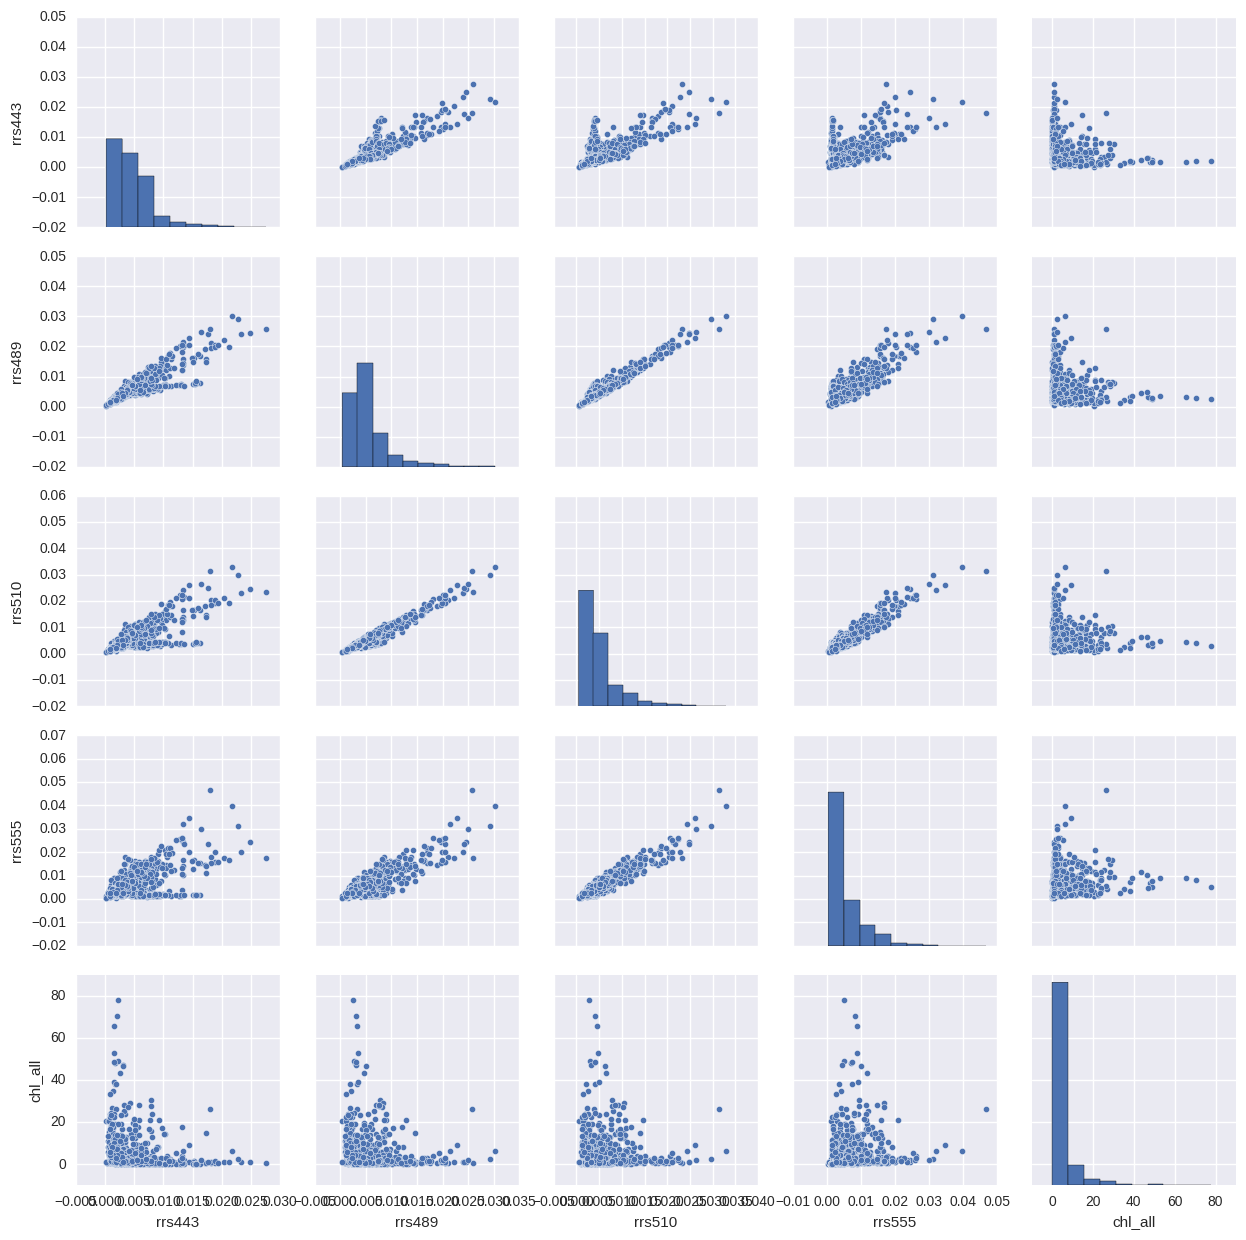

In [55]:
sb.pairplot(dfNomadV2, vars=['rrs443', 'rrs489', 'rrs510', 'rrs555','chl_all'])

Note the apparent strong collinearity among the reflectances. Also the data appears mostly lognormally distributed (*cf. also Campbell et al, 1995*). I'll next create a maxBlue column, and Blue2GreenRatio column. Then I'll log tranform the blue2green ratio and the chlorophyll data put that in a new dataframe. I'll keep the id column in case I need to determine the origin of a particular observation.

In [56]:
dfNomadV2['maxBlue'] = dfNomadV2.loc[:, ['rrs443','rrs489','rrs510']].max(axis=1)
dfNomadV2['blue2green'] = dfNomadV2.maxBlue / dfNomadV2.rrs555

In [57]:
dfLogOCx = pd.DataFrame(columns=['id','mxBl2Gr', 'chl',])
dfLogOCx['id'] = dfNomadV2.id
dfLogOCx['mxBl2Gr'] = np.log10(dfNomadV2.blue2green.values)
dfLogOCx['chl'] = np.log10(dfNomadV2.chl_all.values)

And let's inspect the data again

In [58]:
dfLogOCx.head()

,id,mxBl2Gr,chl
0,1565,-0.267867,1.581950
1,1566,-0.220457,1.544192
2,1567,-0.268537,1.429914
3,1568,-0.279976,1.680879
4,1559,-0.167733,1.371991


In [59]:
dfLogOCx.describe()

,id,mxBl2Gr,chl
count,1016.000000,1016.000000,1016.000000
mean,4598.373031,0.117382,0.089204
std,2318.828613,0.287944,0.702093
min,1441.000000,-0.353183,-1.769551
25%,2118.750000,-0.087723,-0.456596
50%,3702.500000,0.021409,0.068000
75%,7036.250000,0.255020,0.574263
max,7831.000000,0.982648,1.891341


In [60]:
dfLogOCx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 4458
Data columns (total 3 columns):
id         1016 non-null int32
mxBl2Gr    1016 non-null float64
chl        1016 non-null float64
dtypes: float64(2), int32(1)
memory usage: 27.8 KB


Pair plotting just the data relevant to the upcoming regression exercise...

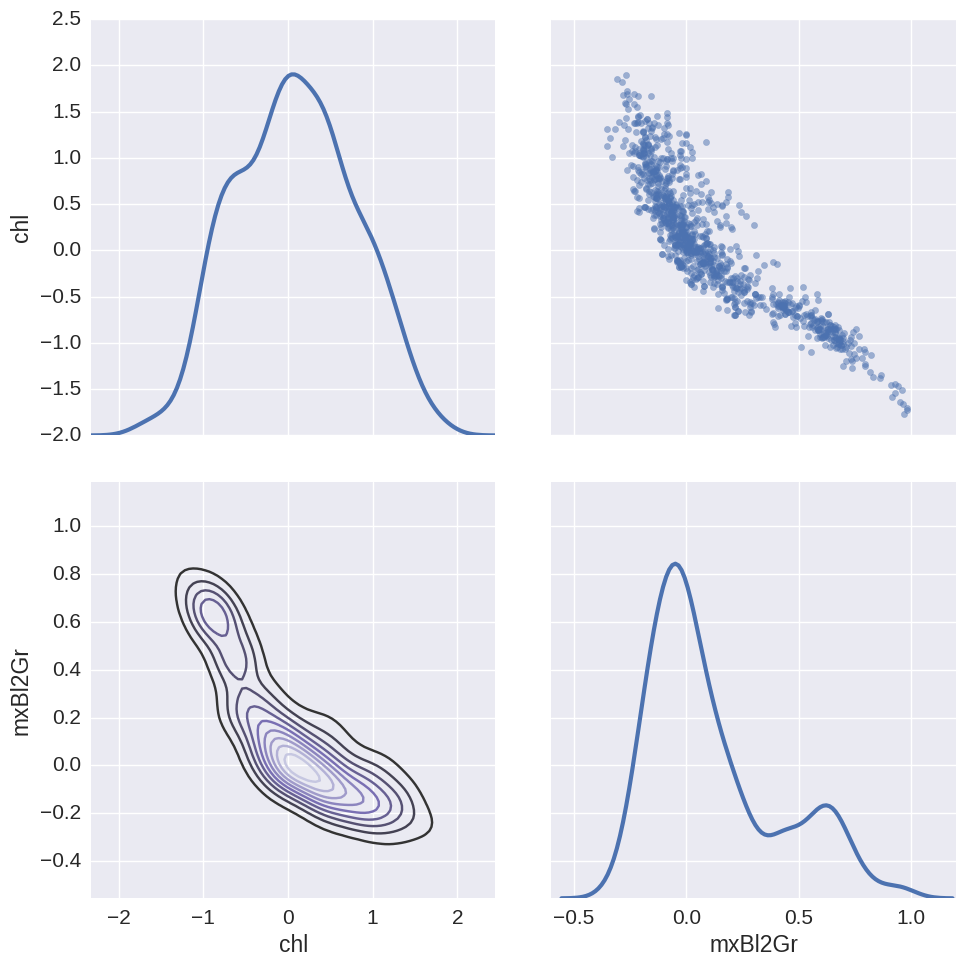

In [90]:
sb.set(font_scale=1.5)
g = sb.PairGrid(dfLogOCx, vars=['chl', 'mxBl2Gr'],size=5, diag_sharey=False);
g = g.map_upper(pl.scatter,alpha=0.5)
g = g.map_diag(sb.kdeplot, lw=3)
g = g.map_lower(sb.kdeplot, cmap="Purples_d");
#g.axes[0,0].set_xticks(np.arange(-0.5,1.5,0.5));

Now fitting the data to a 4th order polynomial regression and printing the coefficents:

In [223]:
myCoefs = FitPoly(dfLogOCx.mxBl2Gr.values,dfLogOCx.chl,lin=False)
print(myCoefs[::-1])

[ 0.24120683 -3.10789592  3.1769156  -0.76503841 -1.38077655]


Let's first confirm the numbers make sense by plotting modeled chl to field data:    

In [92]:
mdlFreq= np.poly1d(myCoefs) # encapsulate the fit results into a polynomial object
chlMdlFreq = mdlFreq(dfLogOCx.mxBl2Gr) # evaluate polynomial with input data

Out of curiosity I'm also going to evaluate the use of OC4v6 coefficients:

$a_i$ = [0.3272, -2.9940, 2.7218, -1.2259, -0.5683]

In [183]:
OC4v6_coeffs = [0.3272, -2.9940, 2.7218, -1.2259, -0.5683]
mdlOC4v6 = np.poly1d(OC4v6_coeffs[::-1])
chlMdlOc4v6 = mdlOC4v6(dfLogOCx.mxBl2Gr)

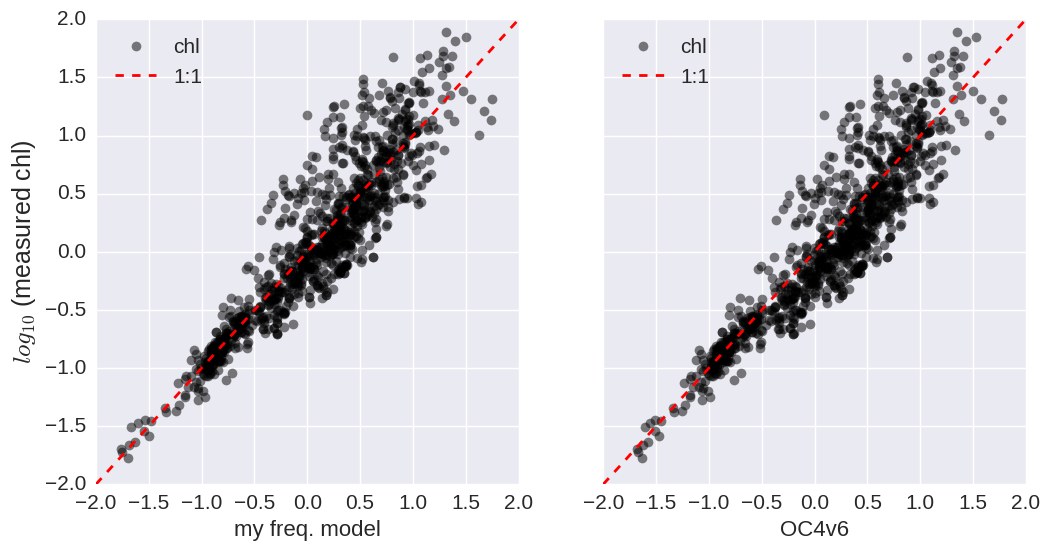

In [116]:
f, axs = pl.subplots(ncols=2,figsize=(12, 6), sharey=True)
for i, (ax, res, name) in enumerate(zip(axs, [chlMdlFreq, chlMdlOc4v6],
                                       ['my freq. model', 'OC4v6'])):
    ax.plot(res, dfLogOCx.chl, 'ko', alpha=0.5);
    ax.plot([-2,2],[-2,2], 'r--',linewidth=2,label='1:1')
    ax.set_xlabel(name, fontsize=16)
    ax.set_xlim((-2,2))
    if i == 0:
        ax.set_ylabel(r'$ log_{10}$ (measured chl)', fontsize=18)

Metrics for my freq. model

In [245]:
print("mse, this fit: %.2f " % mean_squared_error(dfLogOCx.chl.values, chlMdlFreq))
print(r"r^2, this fit: %.2f" % r2_score(dfLogOCx.chl.values, chlMdlFreq))
print("mse, OC4v6: %.2f " % mean_squared_error(dfLogOCx.chl.values, chlMdlOc4v6))
print(r"r^2, OC4v6: %.2f" % r2_score(dfLogOCx.chl.values, chlMdlOc4v6))

mse, this fit: 0.08 
r^2, this fit: 0.83
mse, OC4v6: 0.09 
r^2, OC4v6: 0.82


Bayesian linear regression.
For now, I am simply going to assume I'm still looking for a $4^{th}$ order polynomial. Model comparison will be the subject of a subsequent post.
First I have to specify some priors around the coefficients. I'll assume weakly informative gaussian priors. Before deciding an appropriate distribution for the likelihood, I will check the normality of the  data by way of a normality plot, as well as a comparison between the cummulative distribution function (CDF) of the data and a normal standard distribution.

In [119]:
from scipy.stats import norm

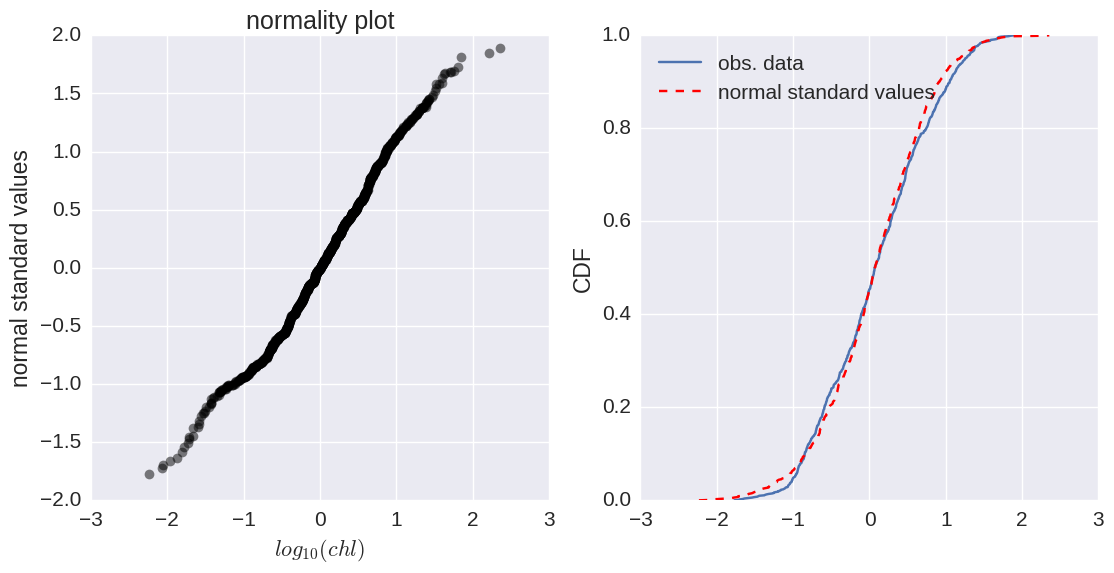

In [178]:
df1,df2,= 100, 10 # possible dof for the t-distribution
normData = norm.rvs(dfLogOCx.chl.mean(),dfLogOCx.chl.std(),
                    size=dfLogOCx.chl.size)
normDataSort = np.sort(normData)
logChlSort = np.sort(dfLogOCx.chl.values)
f,ax = pl.subplots(ncols=2,figsize=(13,6))
lbl = r'$log_{10}(chl)$'
ax[0].plot(normDataSort, logChlSort,'ko', alpha=0.5)
ax[0].set_xlabel('%s' %lbl, fontsize=16)
ax[0].set_ylabel('normal standard values');
ax[0].set_title('normality plot')
ax[1].plot(logChlSort, np.linspace(0,1,logChlSort.size), label='obs. data')
ax[1].plot(normDataSort,np.linspace(0,1,normDataSort.size),'r--', 
          label='normal standard values')
ax[1].set_ylabel('CDF')
ax[1].legend(loc='best')

The above suggests that a normal distribution might be a good candidate to apply to the likelihood.
Next is to setup the bayesian model

In [139]:
ocxRatio = dfLogOCx.mxBl2Gr
chlObs = dfLogOCx.chl

In [179]:
with pm.Model() as model_OCx_norm:
    a0 = pm.Normal('a0', mu=0, sd=10)
    a1 = pm.Normal('a1', mu=0, sd=10)
    a2 = pm.Normal('a2', mu=0, sd=10)
    a3 = pm.Normal('a3', mu=0, sd=10)
    a4 = pm.Normal('a4', mu=0, sd=10)
    epsilon = pm.Uniform('epsilon', lower=0, upper=10)
    mu = a0 + a1 * ocxRatio + a2 * ocxRatio**2 + a3 * ocxRatio**3 + a4 * ocxRatio**4
    chlPred = pm.Normal('chlPred', mu=mu, sd=epsilon, observed=chlObs)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    traceOCx_norm = pm.sample(10000, step=step, start=start)

Optimization terminated successfully.
         Current function value: 203.732359
         Iterations: 19
         Function evaluations: 28
         Gradient evaluations: 28


100%|██████████| 10000/10000 [01:51<00:00, 89.64it/s]


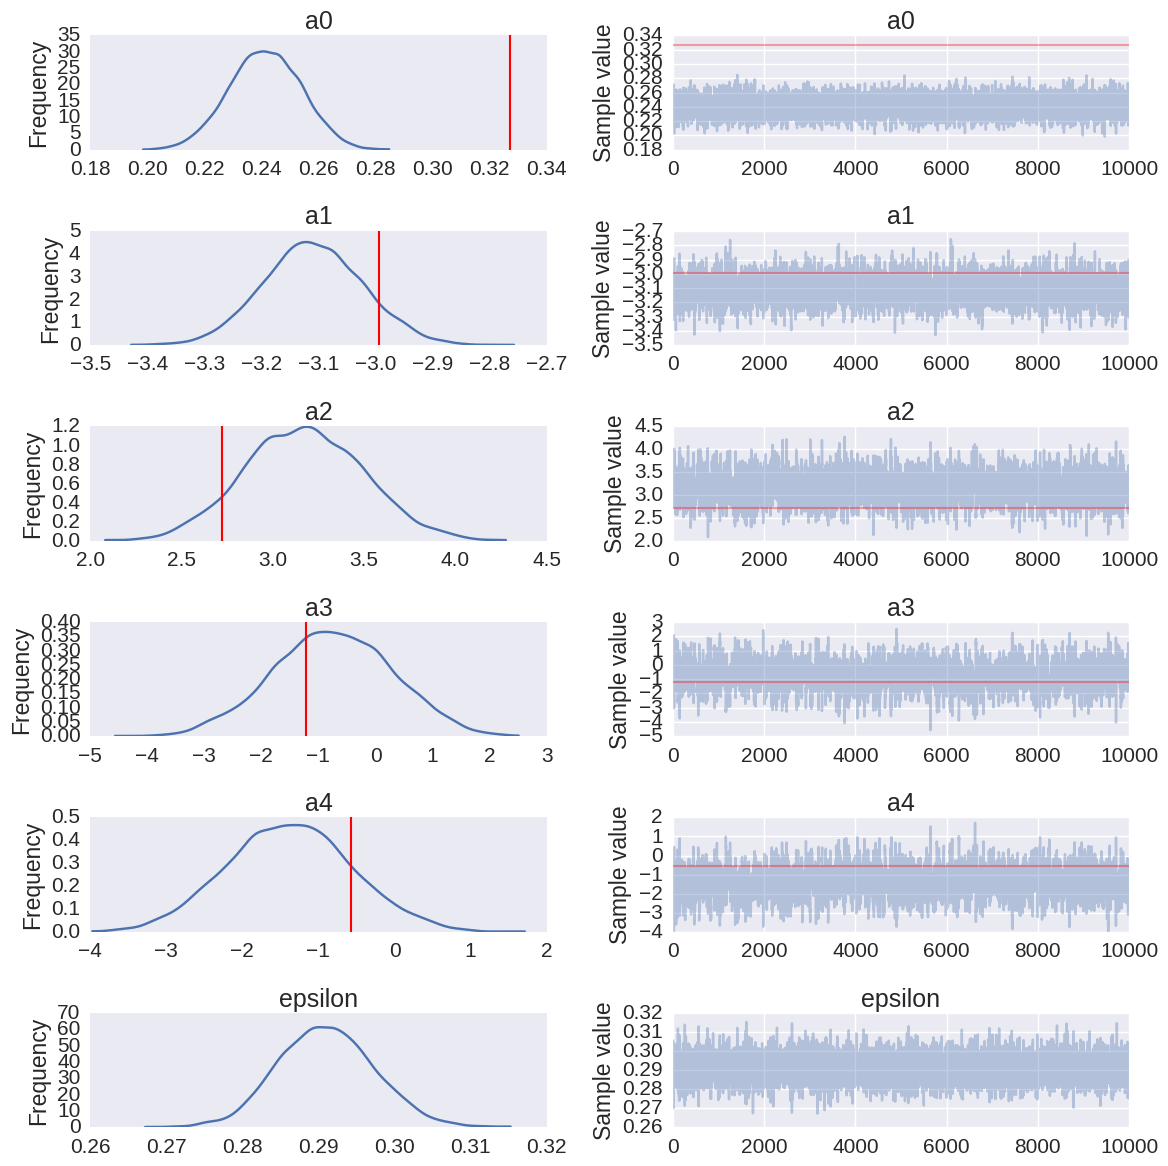

In [184]:
chainOCx_norm = traceOCx_norm[1000:]
varnames=['a%d' %d for d in range(5)]
varnames.append('epsilon')
refvals = {'a%d' %d: rv for d,rv in zip(range(5), OC4v6_coeffs) }
pm.traceplot(traceOCx_norm,varnames=varnames,lines=refvals);

In [186]:
pm.df_summary(chainOCx_norm, varnames=varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a0,0.241392,0.012512,0.000193,0.216324,0.264798
a1,-3.108680,0.088278,0.002119,-3.277213,-2.933986
a2,3.166527,0.323015,0.008580,2.509019,3.763759
a3,-0.745941,1.036021,0.033109,-2.725443,1.330486
a4,-1.387843,0.814465,0.025531,-2.896192,0.291232
epsilon,0.290971,0.006337,0.000062,0.279185,0.303596


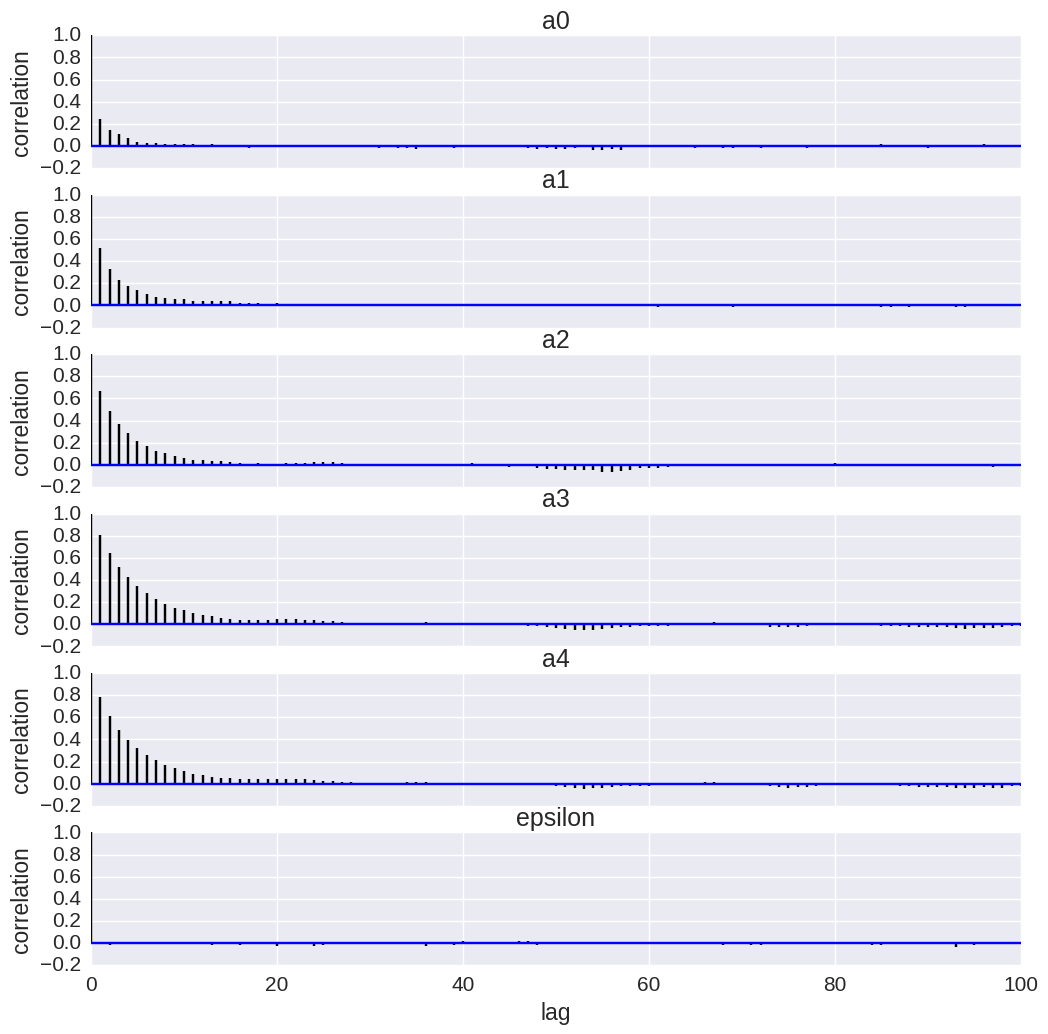

In [187]:
pm.autocorrplot(chainOCx_norm, varnames=varnames);

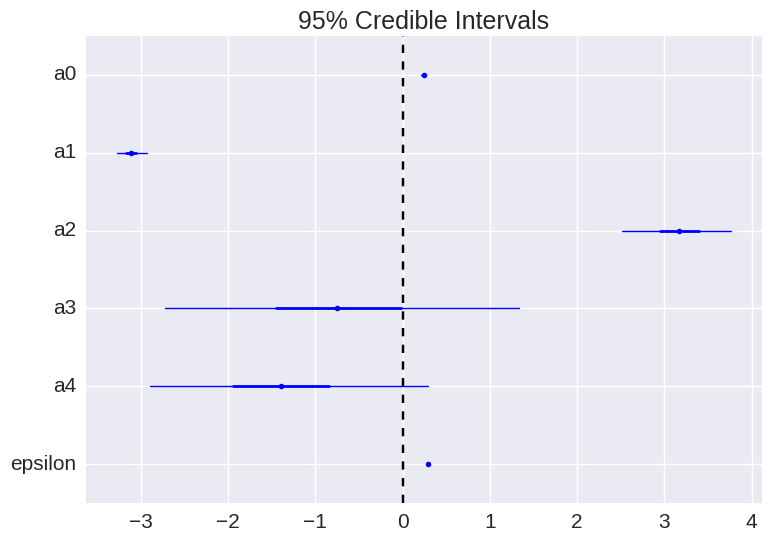

In [189]:
pm.forestplot(chainOCx_norm,varnames=varnames)

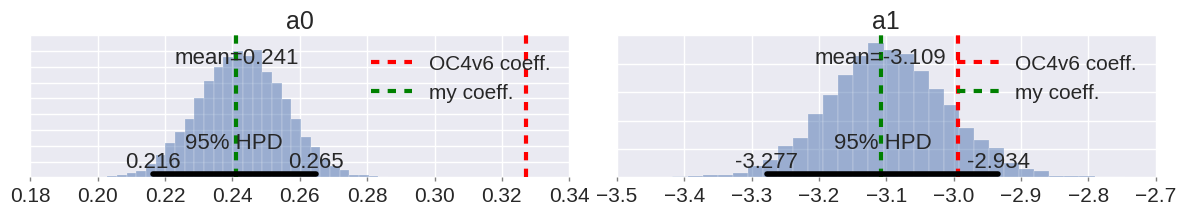

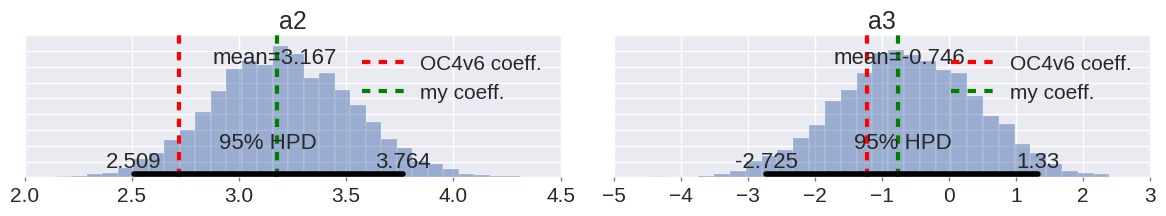

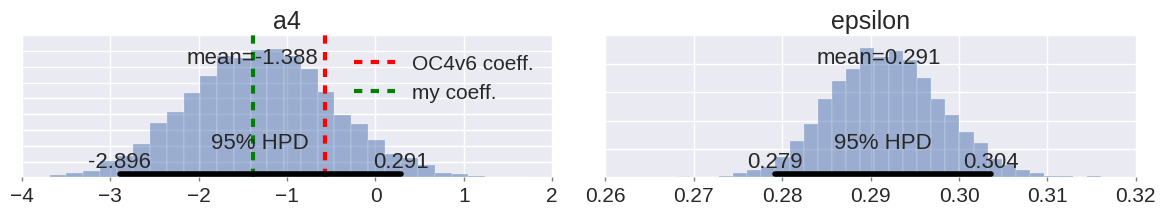

In [251]:
for i in range(1, len(varnames)+1, 2):
    vars2 = varnames[max(0, i-1): i+1]
    axs = pm.plot_posterior(chainOCx_norm, varnames=vars2, alpha=0.5)
    for ax,rv_oc4v6, rv_mycf in zip(axs,OC4v6_coeffs[max(0,i-1):i+1],myCoefs[::-1][max(0,i-1):i+1]):
        ax.vlines(rv_oc4v6, 0, ax.get_ylim()[1], colors='r', linewidth=3,
                  linestyle='--', label='OC4v6 coeff.')
        ax.vlines(rv_mycf, 0, ax.get_ylim()[1], colors='g', linewidth=3,
                  linestyle='--', label='my coeff.')
        ax.legend()

In [228]:
myChlModl=0
oc4V6Modl=0
chlBayes=0
ocxRatioMock = np.linspace(ocxRatio.min(),ocxRatio.max(),100)
for i in range(5):
    myChlModl+= myCoefs[::-1][i] * ocxRatioMock**i
    oc4V6Modl += OC4v6_coeffs[i] * ocxRatioMock**i
    chlBayes += chainOCx_norm['a%d' %i].mean()*ocxRatioMock**i

In [229]:
idx = np.argsort(ocxRatio.values)
ocxRatio_ord = ocxRatio.values[idx]
ppc = pm.sample_ppc(chainOCx_norm, samples=1000, model=model_OCx_norm)
sig0 = pm.hpd(ppc['chlPred'], alpha=0.5)[idx]
sig1 = pm.hpd(ppc['chlPred'], alpha=0.05)[idx]

100%|██████████| 1000/1000 [00:21<00:00, 47.34it/s]


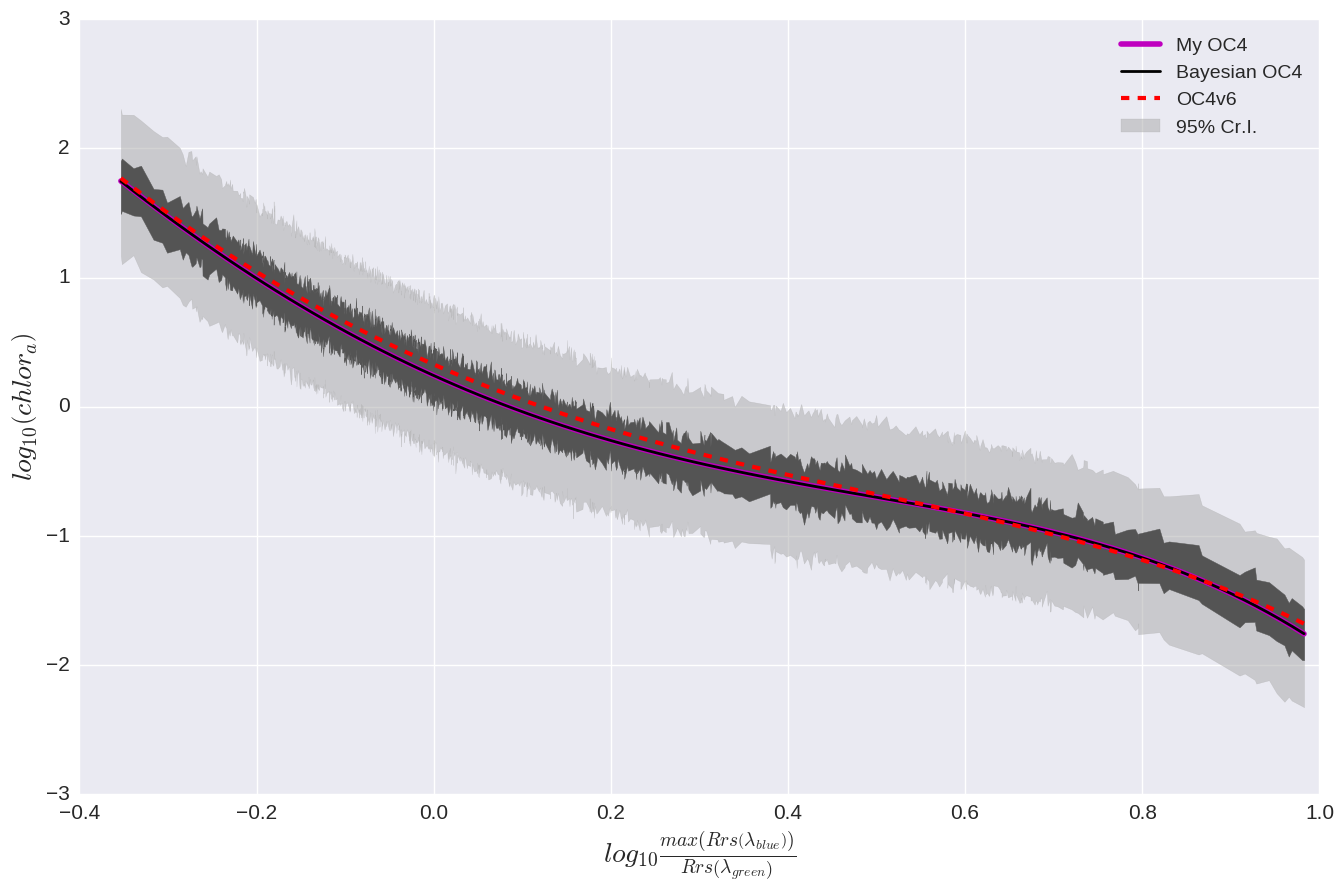

In [261]:
pl.figure(figsize=(16,10))
pl.fill_between(ocxRatio_ord, sig0[:,0], sig0[:,1], color='k', alpha=1)
pl.fill_between(ocxRatio_ord, sig1[:,0], sig1[:,1], color='darkgray', alpha=0.5, label='95% Cr.I.')
pl.plot(ocxRatioMock,myChlModl,'m', linewidth=4, label='My OC4')
pl.plot(ocxRatioMock,chlBayes,'k', linewidth=2, label='Bayesian OC4')
pl.plot(ocxRatioMock,oc4V6Modl,'r', linewidth=3, linestyle='--', label='OC4v6')
pl.xlabel(r'$log_{10}\frac{max(Rrs\left(\lambda_{blue}\right))}{Rrs\left(\lambda_{green}\right)}$', fontsize=20)
pl.ylabel(r'$log_{10}\left(chlor_a\right)$', fontsize=20);
pl.legend(fontsize=14);

Let's calculate metrics for this model

In [248]:
chlBayesReal=0
for i in range(5):
    chlBayesReal += chainOCx_norm['a%d' %i].mean()*ocxRatio**i

In [249]:
print("mse, this fit: %.2f " % mean_squared_error(dfLogOCx.chl.values, chlMdlFreq))
print("r^2, this fit: %.2f" % r2_score(dfLogOCx.chl.values, chlMdlFreq))
print("mse, OC4v6: %.2f " % mean_squared_error(dfLogOCx.chl.values, chlMdlOc4v6))
print("r^2, OC4v6: %.2f" % r2_score(dfLogOCx.chl.values, chlMdlOc4v6))
print("mse, Bayes chl: %.2f" % mean_squared_error(dfLogOCx.chl.values, chlBayesReal))
print("r^2, Bayes chl: %.2f" % r2_score(dfLogOCx.chl.values, chlBayesReal))

mse, this fit: 0.08 
r^2, this fit: 0.83
mse, OC4v6: 0.09 
r^2, OC4v6: 0.82
mse, Bayes chl: 0.08
r^2, Bayes chl: 0.83


So the Bayesian fit matches the least squares fit, as expected since I used relatively uninformative priors. However,  this process also spits out uncertainties for the model fit, including credibility intervals around the coefficients.

That's it for bayesian polynomial regression. In a subsequent post, I'll find an excuse to explore the recasting of this model into a hierarchical framework.